In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
import random
import math
import time
from tqdm.notebook import tqdm

from typing import Tuple

import sys
sys.path.append("..")
from dataset import iterator

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

____

# Input Embedding

In [3]:
class InputEmbedding(nn.Module) : 
    def __init__(self, vocab_size, seq_length, d_model) : 
        super().__init__()
        self.d_model = d_model
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=train_dataset.prep.pad_id)
        self.pos_emb = nn.Embedding(seq_length, d_model)
        self.seg_emb = nn.Embedding(3, d_model, padding_idx=train_dataset.prep.pad_id)
        
    def generate_enc_mask_m(self, src) :       
        mask_m = (src != train_dataset.prep.pad_id).unsqueeze(1).unsqueeze(2)
        return mask_m
    
    def forward(self, txt, seg) : 
        emb = self.tok_emb(txt)
        pos = torch.arange(0, emb.shape[1]).unsqueeze(0).repeat(emb.shape[0], 1).to(emb.device)
        summed = emb + self.pos_emb(pos) + self.seg_emb(seg)
        return summed

# Scaled Dot-Product Attention

In [4]:
class ScaledDotProductAttention(nn.Module) : 
    def __init__(self, d_model) : 
        super().__init__()
        self.d_model = d_model
        self.fc = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask) :         
        score = torch.matmul(q, k.permute(0,1,3,2).contiguous())/math.sqrt(d_model)
        score = score.masked_fill(mask==0, -1e10)
        scaled_score = torch.softmax(score, dim=-1)
        
        attention = torch.matmul(scaled_score, v).permute(0,2,3,1).contiguous()
        attention = attention.view(attention.shape[0], attention.shape[1], self.d_model)
        
        return self.fc(attention)

___

# Multi-Head Attention

In [5]:
class MultiHeadAttention(nn.Module) : 
    def __init__(self, d_model, seq_length, n_head) : 
        super().__init__()
        assert d_model % n_head == 0, f"n_head({n_head}) does not divide d_model({d_model})"

        self.n_div_head = d_model//n_head
        self.d_model = d_model
        self.seq_len = seq_length
        self.n_head = n_head

        self.Q = nn.Linear(d_model,  d_model)
        self.K = nn.Linear(d_model,  d_model)
        self.V = nn.Linear(d_model,  d_model)
        
    def div_and_sort_for_multiheads(self, projected, seq_len) : 
        div = projected.view(projected.shape[0], self.n_head, seq_len, self.n_div_head)
        return div
    
    def forward(self, emb) :
        q = self.div_and_sort_for_multiheads(self.Q(emb), self.seq_len)    
        k = self.div_and_sort_for_multiheads(self.K(emb), self.seq_len)
        v = self.div_and_sort_for_multiheads(self.V(emb), self.seq_len)

        return q,k,v

# Post-process the sub-layer

In [6]:
class PostProcessing(nn.Module) : 
    def __init__(self, d_model, p=0.1) : 
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p)
        
    def forward(self, emb, attn) : 
        return self.ln(emb+self.dropout(attn))

# Position-wise FFN

In [7]:
class PositionwiseFFN(nn.Module) : 
    def __init__(self, d_model, d_ff) : 
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.act = nn.GELU()
        
    def forward(self, x) : 
        return self.fc2(self.act(self.fc1(x)))

# Encoder

In [8]:
class EncoderLayer(nn.Module) : 
    def __init__(self, vocab_size, seq_length, d_model, d_ff, n_head, dropout_p) : 
        super().__init__()
        
        self.ma = MultiHeadAttention(d_model, seq_length, n_head).to(device)
        self.sdp = ScaledDotProductAttention(d_model)
        
        self.pp1 = PostProcessing(d_model, dropout_p)
        self.pp2 = PostProcessing(d_model, dropout_p)
        
        self.positionwise_ffn = PositionwiseFFN(d_model, d_ff)
            
    def forward(self, emb, mask_m) :

        q,k,v = self.ma(emb)    
        attn = self.sdp(q,k,v, mask=mask_m)
        
        attn = self.pp1(emb, attn)
        z = self.positionwise_ffn(attn)

        return self.pp2(attn, z)

# BERT

In [9]:
class BERT(nn.Module) : 
    def __init__(self,
                 vocab_size,
                 seq_length,
                 d_model,
                 d_ff,
                 n_head,
                 dropout_p,
                 n_enc_layer) : 
        
        super().__init__()
        
        self.embber = InputEmbedding(vocab_size, seq_length, d_model)
        
        enc = EncoderLayer(vocab_size, seq_length, d_model, d_ff, n_head, dropout_p)
        
        self.enc = nn.ModuleList([deepcopy(enc) for _ in range(n_enc_layer)])
        
        self.mlm_fc = nn.Linear(d_model, vocab_size)
        self.nsp_fc = nn.Linear(d_model, 1)

    def forward(self, txt, seg) : 
        
        emb = self.embber(txt, seg)
        mask_m = self.embber.generate_enc_mask_m(txt)

        for enc_layer in self.enc : 
            emb = enc_layer(emb, mask_m)

        return torch.log_softmax(self.mlm_fc(emb), dim=2), torch.sigmoid(self.nsp_fc(emb[:,0]))

In [10]:
batch_size = 128
seq_len = 128

train_dataset = iterator.BertIterator(filename = '../data/prep_train.txt',
                                tokenizer_model_path = '../data/m.model',
                                seq_len=seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = iterator.BertIterator(filename = '../data/prep_valid.txt',
                                tokenizer_model_path = '../data/m.model',
                                seq_len=seq_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [11]:
d_model = 64
d_ff = d_model * 4
n_head = 8
vocab_size = train_dataset.prep.vocab_size
dropout_p = 0.1
n_enc_layer = 3
seq_length = train_dataset.seq_len

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model = nn.DataParallel(BERT(vocab_size,
             seq_length,
             d_model,
             d_ff,
             n_head,
             dropout_p,
             n_enc_layer)).to(device)

____

# Set Label weight
- mlm's label has huge imbalance within it, sampling the labels and prepare the weight arr for its label

In [13]:
mlm_label_container = []
cnt = 0

for data in tqdm(train_dataloader, total=len(train_dataloader)) : 
    mlm = data['mlm'][data['mlm'] != 0]
    mlm_label_container.append(mlm)
    cnt += 1
    if cnt == 2000 : 
        break

  0%|          | 0/26566 [00:00<?, ?it/s]

In [14]:
count_arr = torch.unique(torch.cat(mlm_label_container), return_counts=True)
weight = -torch.log(count_arr[1] / count_arr[1].sum())
weight_arr = torch.full((vocab_size,), fill_value=weight.median().item()).type(torch.FloatTensor)
weight_arr[count_arr[0]] = weight

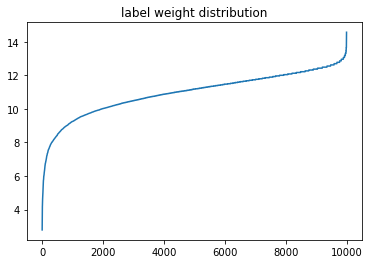

In [15]:
plt.title("label weight distribution")
plt.plot(torch.sort(weight_arr).values.data.numpy())
# plt.xlim(0, 100)
plt.show()

____

# Train

In [16]:
# torch.autograd.set_detect_anomaly(True) # -- for debugging the train progress --
N_EPOCHS = 20

criterion1 = nn.NLLLoss(ignore_index=train_dataset.prep.pad_id, weight=weight_arr).to(device)
criterion2 = nn.BCELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, pct_start=0.01, 
                                          steps_per_epoch=len(train_dataloader), epochs=N_EPOCHS, 
                                          total_steps=N_EPOCHS * len(train_dataloader), anneal_strategy='linear')

In [17]:
def train(model, dataloader, optimizer, scheduler):
    
    model.train()
    
    epoch_total_loss = 0
    epoch_mlm_loss = 0
    epoch_nsp_loss = 0 
    
    epoch_mlm_acc = 0    
    epoch_nsp_acc = 0    
    cnt = 0
    
    for data in tqdm(dataloader, desc='train') :
        
        drop_data_bool = (data['seg'] == 1).sum(1) / data['seg'].shape[1] < 0.6
        data = {k:v[drop_data_bool].to(device) for k,v in data.items()}
        
        optimizer.zero_grad()        
        mlm_pred, nsp_pred = model(data['text'], data['seg'])
        
        mlm_loss = criterion1(mlm_pred.transpose(1,2), data['mlm'])
        nsp_loss = criterion2(nsp_pred.squeeze(), data['nsp'].float().cuda())
        loss = mlm_loss + nsp_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()        
        
        acc = (mlm_pred.view(-1,vocab_size).argmax(1) == data['mlm'].view(-1)).sum().item() / data['mlm'].view(-1).shape[0]
        epoch_mlm_acc += acc
        
        acc = (nsp_pred.argmax(1) == data['nsp']).sum() / data['nsp'].shape[0]
        epoch_nsp_acc += acc
        
        epoch_total_loss += loss.item()
        epoch_mlm_loss += mlm_loss.item()
        epoch_nsp_loss += nsp_loss.item()        
        cnt += 1
        
        if cnt % (len(dataloader)//1000) == 0 : 
            print(f'\tTrain Total Loss: {epoch_total_loss / cnt:.3f} | Train MLM Loss: {epoch_mlm_loss / cnt:.3f} | Train NSP Loss: {epoch_nsp_loss / cnt:.3f}\
            | MLM ACC : {epoch_mlm_acc / cnt: .3f} | NSP ACC : {epoch_nsp_acc / cnt: .3f} | Learning Rate : {scheduler.get_last_lr()[0]:.3f}')

        scheduler.step()
        
    return epoch_total_loss / cnt, epoch_mlm_loss / cnt, epoch_nsp_loss / cnt

def evaluate(model, dataloader, criterion):
    
    model.eval()
    
    epoch_total_loss = 0
    epoch_mlm_loss = 0
    epoch_nsp_loss = 0
    cnt = 0
    
    with torch.no_grad() : 
        for data in tqdm(data, desc='valid') :
            
            emb, mlm_pred, nsp_pred = model(data['text'].to(device), data['seg'].to(device))
        
            mlm_loss = criterion(mlm_pred.transpose(1,2), data['mlm'].cuda())
            nsp_loss = criterion(nsp_pred, data['nsp'].cuda()) 
            loss = mlm_loss + nsp_loss

            epoch_total_loss += loss.item()
            epoch_mlm_loss += mlm_loss.item()
            epoch_nsp_loss += nsp_loss.item()        
            cnt += 1
    
        if cnt % (len(dataloader)//100) == 0 : 
            print(f'\tTrain Total Loss: {epoch_total_loss / cnt:.3f} | Train MLM Loss: {epoch_mlm_loss / cnt:.3f} | Train NSP Loss: {epoch_nsp_loss / cnt:.3f}')
            
    return epoch_total_loss / cnt, epoch_mlm_loss / cnt, epoch_nsp_loss / cnt

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_total_loss, train_mlm_loss, train_nsp_loss = train(model, train_dataloader, optimizer, scheduler)
    valid_total_loss, valid_mlm_loss, valid_nsp_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_total_loss < best_valid_loss:
        best_valid_loss = valid_total_loss
        torch.save(model.state_dict(), 'bert.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    
    print(f'\tTrain Total Loss: {train_total_loss:.3f} | Train MLM Loss: {train_mlm_loss:.3f} | Train NSP Loss: {train_nsp_loss:.3f}')
    
    print(f'\tValid Total Loss: {valid_total_loss:.3f} | Valid MLM Loss: {valid_mlm_loss:.3f} | Valid NSP Loss: {valid_nsp_loss:.3f}')

train:   0%|          | 0/26566 [00:00<?, ?it/s]

	Train Total Loss: 8.681 | Train MLM Loss: 7.982 | Train NSP Loss: 0.699            | MLM ACC :  0.007 | NSP ACC :  0.502 | Learning Rate : 0.004
	Train Total Loss: 8.434 | Train MLM Loss: 7.735 | Train NSP Loss: 0.698            | MLM ACC :  0.007 | NSP ACC :  0.496 | Learning Rate : 0.005


In [ ]:
for data in train_dataloader : 
    mlm_pred, nsp_pred = model(data['text'], data['seg'])
    break